# Guia para hacer un modelo de ia del examen


## Ejercicio 1: Limpiar los datos



### QUITANDO FILAS Y COLUMNAS Y NORMALIZANDO DATOS

Para normalizar los datos hay que tener en cuenta que:
    
    Discretos/Enumerados/Cualitativos -> OneHotEncoding o Labled Encoder
        OneHotEncoding -> por defecto, si dudas usa este
        LabledEncoder -> si los valores tienen un orden

    Continuos -> StandardScaling, para normalizarlos y llevarlos a una escala comun



    -> solo deberia hacer falta copiar este codigo y cambiar las columnas en ATRIBUTOS, en final_data salen todos los datos sin el atributo solucion y en labeled_data el solucion

In [ ]:
# imports
import glob as glob
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


# ---------------------------- / LECTURA DE DATOS / ----------------------------------
data = pd.read_csv("dementia_dataset.csv")

# TRUCO: Antes de rellenar las listas de abajo, haz un print(data.info()) 
# y un print(data.describe(include='all')) en una celda aparte para ver qué columnas hay.



# ---------------- / GESTIÓN DE NULOS / ------------------- 
# ----- DIAGNOSTICO
# print("--- INFO ---")
# print(data.info())
# print("\n--- NULOS POR COLUMNA ---")
# print(data.isnull().sum()) # ¡ESTO ES CRUCIAL!
# Si ves una columna con 50% de nulos -> A la lista 'unnecessary_columns'
# Si ves una columna con 5% de nulos -> Imputar (media) o Borrar filas

# Cuantos datos perderiamos: 
    # Si se pierden 10-15 filas OPCION A
    # si se pierden 50-100 filas OPCION B

# ----- QUITAR / MODIFICAR NULOS
# OPCIÓN A : Borrar filas con huecos.
# Úsalo si tienes muchos datos (>1000) y pocos huecos.
#final_data = data.dropna(how="any")

# OPCIÓN B (Alternativa si tienes pocos datos): IMPUTAR
# Si ves que al hacer dropna te quedas con muy pocas filas, usa esto antes de escalar:
# data['SES'] = data['SES'].fillna(data['SES'].mean()) # Imputa la media en los huecos 
# data['...'] = data['...'].fillna(data['...'].median()) # Imputa la mediana en los huecos 
# Verificamos que ya no quedan nulos
print("Nulos restantes:", data.isnull().sum().sum())





# --------------- / ATRIBUTOS / ---------------------
unnecessary_columns = ["Subject ID", "MRI ID", "Hand"]
oneHot_columns = ["M/F"]
standardScaling_columns = ["Age", "EDUC", "SES", "MMSE", "CDR", "eTIV", "nWBV", "ASF", "Visit", "MR Delay"]
labeled_columns = ["Group"] # SOLUCION



# ---------------- / DROP /  -------------------
# Borramos lo que no sirve para limpiar el ruido del dataset.
final_data = data.drop(columns=unnecessary_columns) 
# ----------------------------------------------------------------------


# ---------------- / OHE /  -------------------
encoder = OneHotEncoder(sparse_output=False) 
encoder_final = encoder.fit_transform(data[oneHot_columns])  
# Creamos un DF temporal con nombres bonitos (ej: "M/F_M", "M/F_F")
oneHot_df = pd.DataFrame(encoder_final, columns=encoder.get_feature_names_out(oneHot_columns))


# ---------------- / SCALER /  -------------------
# Transforma los datos para que tengan media 0 y desviación típica 1 (Curva de Gauss).
scaler = StandardScaler()
scaler_final = scaler.fit_transform(data[standardScaling_columns])
df_sc = pd.DataFrame(scaler_final, columns=standardScaling_columns, index=data.index)



# ----------------- / LABELED ENCODER / -------------------------   
# Convierte "Demented" -> 0, "Nondemented" -> 1, etc.
labler = LabelEncoder()
labeled_final = labler.fit_transform(data[labeled_columns].values.ravel()) # o labeled_final = labler.fit_transform(data[labeled_columns])
df_lbl = pd.DataFrame(labeled_final, columns=labeled_columns, index=data.index)
# ----------------------------------------------------------------------

# ---------------- / CONCATENAR (SOLUCION AL FINAL) / -------------------
# ---- 1. Juntamos las 3 partes: Numéricos Escalados + Categóricos OHE + Solución Codificada
final_data = pd.concat([df_sc, oneHot_df, df_lbl], axis=1) #axis=1 significa "pegar columnas a la derecha"


final_data.head()

# ---------------- / OPCIONAL / -------------------
# # Opcional: prints para verificar
# print("Tamaño final del dataset:", final_data.shape)
# # para guardarlas en un archivo (opcional)
# final_data.to_csv("./examen_limpio.csv", index=False)


c:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Slices

La sintaxis de slicing ([:]) es la herramienta número 1 para trocear tus datos. Casi siempre tendrás un CSV donde la última columna es la solución (ej: HeartDisease o Group). Usando pandas: 
* dataset.iloc[:, :-1] $\to$ Coge TODAS las filas (:) y TODAS las columnas MENOS la última (:-1). $\to$ Esto es tu X.dataset.
* iloc[:, -1] $\to$ Coge TODAS las filas (:) y SOLO la última columna (-1). $\to$ Esto es tu y.

#### Ejemplo práctico de examen
1. Separar features y target
* X = final_data.iloc[:, :-1]  # Todo menos la solución
* y = final_data.iloc[:, -1]   # Solo la solución

2. Dividir datos manualmente (Train / Test)
Si no te dejan usar train_test_split de sklearn (raro, pero posible) o si son series temporales (donde no puedes mezclar aleatoriamente):
* datos[:800] $\to$ Coge desde el principio hasta la fila 800 (Entrenamiento).
* datos[800:] $\to$ Coge desde la fila 800 hasta el final (Test).

3. Imágenes (CNNs)
Si te cae algo de imágenes (matrices 3D: Alto, Ancho, Canales):
* imagen[:, ::-1] $\to$ Invierte la imagen horizontalmente (Efecto espejo para Data Augmentation).
* imagen[10:100, 10:100] $\to$ Recorta la imagen (Crop) para quitar bordes inútiles.

In [1]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
start = 0
stop = 2
step = 1

a[start:stop]  # items start through stop-1
a[start:]      # items start through the rest of the array
a[:stop]       # items from the beginning through stop-1
a[:]           # a copy of the whole array

# ---------------------------------------------

a[start:stop:step] # start through not past stop, by step

# ---------------------------------------------

a[-1]    # last item in the array
a[-2:]   # last two items in the array
a[:-2]   # everything except the last two items

# ---------------------------------------------

a[::-1]    # all items in the array, reversed
a[1::-1]   # the first two items, reversed
a[:-3:-1]  # the last two items, reversed
a[-3::-1]  # everything except the last two items, reversed


[7, 6, 5, 4, 3, 2, 1, 0]

## Ejercicio 2: Representar los datos


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# -------------------- / PREPARACIÓN / -------------------
x = final_data                          # x: Son tus datos limpios (sin la solución). Ya lo tienes del Ejercicio 1.
y = df_lbl.values.ravel()     # y: Es la columna de solución. Úsala directa de 'labeled_data' (Ejercicio 1).
                                        # .values.ravel() asegura que sea un array plano y no de problemas.

# clase: TIENE QUE SER UN STRING, NO UNA LISTA
clase = "Group"        # variable solucion

color = y  #codificando cada action como un color



# ---------------- / DISTRIBUCIÓN DE CLASES / -------------------
# Úsalo si piden "Ver distribución de clases" o "Balanceo del dataset"
print(f"--- Distribución de {clase} ---")
plt.figure(figsize=(6, 4))

# TRUCO PRO: Usamos 'data' (el original) en vez de 'labeled_data' para que
# en el gráfico salgan los nombres ("Demented") en vez de números (0, 1).
# Si usas 'labeled_data' saldrán 0, 1, 2.
                                      
data[clase].value_counts().plot(kind='bar', color=['skyblue', 'orange']) # pon mas colores si hace falta
plt.title(f"Distribución de la variable objetivo: {clase}")
plt.xlabel("Clases")
plt.ylabel("Cantidad de pacientes")
plt.xticks(rotation=0) # Para que las letras se lean rectas
plt.grid(axis='y', alpha=0.3)
plt.show()


# ------------------- / PCA (Reducción) / ------------------------ 
pca_comp = PCA(n_components=2)
x_pca = pca_comp.fit_transform(x)

# Cuanta info mantenemos:
print(f"Varianza explicada: {pca_comp.explained_variance_ratio_.sum():.2f}") 

df_pca = pd.DataFrame({
    "c1": x_pca[:, 0],    # Componente Principal 1
    "c2": x_pca[:, 1],    # Componente Principal 2
    clase: y                # el color (0,1,2...)
})

grupos = sorted(df_pca[clase].unique()) # [0, 1, 2]
    
    

# ---------------------------- / PINTADO / ------------------------ 
# Colores: Usamos un mapa de colores automático
colormap = plt.get_cmap("viridis")
colors = colormap(np.linspace(0, 1, len(grupos)))

for i, g in enumerate(grupos):
    # Filtramos los puntos de ese grupo
    subset = df_pca[df_pca[clase] == g]
    
    # --- ETIQUETAS REALES (Demented vs 0) ---
    # Intentamos recuperar el nombre real usando el 'labler' del Ejercicio 1.
    try:
        nombre_real = labler.inverse_transform([g])[0]
    except:
        nombre_real = f"Clase {g}" # Si falla, ponemos Clase 0, Clase 1...
    
    plt.scatter(
        subset["c1"], 
        subset["c2"],
        color=colors[i],
        alpha=0.7,
        s=80,             # Tamaño del punto
        label=nombre_real # ¡Importante para la leyenda!
    )

plt.legend(title="Estado del Paciente")
plt.title("PCA: Visualización de datos tras limpieza")
plt.xlabel(f"Componente 1 ({pca_comp.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"Componente 2 ({pca_comp.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'final_data' is not defined

## Ejercicio 3: MLP

In [ ]:
# ==============================================================================
# EJERCICIO 3: ENTRENAMIENTO Y EVALUACIÓN DEL MLP
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------------------------------------------------------
# 1. COPIA AQUÍ TU CLASE 'MultilayerPerceptron' ENTERA
# ---------------------------------------------------------

class MultilayerPerceptron:
    def __init__(self, layers, learning_rate=0.1, epochs=5000):
        self.layers = layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.loss_history = []
        
        np.random.seed(42) 
        for i in range(len(layers) - 1):
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        input_data = X
        for i in range(len(self.weights) - 1):
            z = np.dot(input_data, self.weights[i]) + self.biases[i]
            a = self.sigmoid(z) 
            activations.append(a)
            input_data = a
        z_last = np.dot(input_data, self.weights[-1]) + self.biases[-1]
        activations.append(self.softmax(z_last))
        return activations

    def backpropagation(self, X, y_onehot, activations):
        m = X.shape[0]
        deltas = [activations[-1] - y_onehot]
        for i in range(len(self.weights) - 2, -1, -1):
            delta_prev = np.dot(deltas[-1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            deltas.append(delta_prev)
        deltas.reverse()
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * (np.dot(activations[i].T, deltas[i]) / m)
            self.biases[i] -= self.learning_rate * (np.sum(deltas[i], axis=0, keepdims=True) / m)

    def fit(self, X, y):
        y = y.astype(int) 
        y_onehot = np.eye(len(np.unique(y)))[y]
        print(f"Entrenando MLP Propio: {self.layers}")
        for epoch in range(self.epochs):
            activations = self.forward(X)
            self.backpropagation(X, y_onehot, activations)
            if epoch % (self.epochs // 10) == 0:
                loss = -np.mean(np.sum(y_onehot * np.log(activations[-1] + 1e-8), axis=1))
                self.loss_history.append(loss)
                print(f"   Epoch {epoch}: Loss {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X)[-1], axis=1)


In [ ]:
# ---------------------------------------------------------
# 2. PREPARACIÓN DE DATOS (CRUCIAL: PANDAS -> NUMPY)
# ---------------------------------------------------------
# Tu clase no entiende DataFrames, solo Arrays de Numpy.
# 'final_data' y 'df_lbl' vienen de tu limpieza previa.

# Convierte DataFrame a Matriz Numpy
X_numpy = final_data.values     
# Convierte Series a Array Numpy ---
y_numpy = df_lbl.values.ravel()# Usamos .ravel() para asegurar que sea [0, 1, 2...] y no [[0], [1], [2]...]


print(f"Shape de X: {X_numpy.shape}")
print(f"Shape de y: {y_numpy.shape}") # Debe poner (N,) y NO (N, 1)

# División Train / Test (80% - 20%)
# stratify=y_numpy es OBLIGATORIO en exámenes para que las clases estén balanceadas en el test
X_train, X_test, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y_numpy
)

# ---------------------------------------------------------
# 3. CONFIGURACIÓN DE LA RED
# ---------------------------------------------------------
input_dim = X_train.shape[1]         # Número de neuronas de entrada (automático)
output_dim = len(np.unique(y_numpy)) # Número de clases/salidas (automático)

# EL ENUNCIADO PIDE: "Prueba con más de una capa oculta".
# Estructura: [Entrada, Oculta1, Oculta2, ..., Salida]
# Recomendación examen: Empieza con algo potente como [input, 64, 32, output]
layer_structure = [input_dim, 64, 32, output_dim] 

# ---------------------------------------------------------
# 4. INSTANCIAR Y ENTRENAR
# ---------------------------------------------------------
print(f"--- Entrenando Modelo con estructura: {layer_structure} ---")

# CONSEJOS HIPERPARÁMETROS SI EL ACCURACY ES BAJO:
# 1. learning_rate: Prueba 0.1, 0.01, 0.001. Si es muy alto oscila, si es muy bajo no aprende.
# 2. epochs: Sube a 10000 o 20000 si la curva de loss sigue bajando.
mi_mlp = MultilayerPerceptron(layers=layer_structure, learning_rate=0.1, epochs=10000)

mi_mlp.fit(X_train, y_train)

# ---------------------------------------------------------
# 5. EVALUACIÓN Y RESULTADOS
# ---------------------------------------------------------
# Predicción
y_pred = mi_mlp.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n>>> ACCURACY CONSEGUIDO: {acc*100:.2f}%")

if acc < 0.65:
    print("⚠️ ALERTA: No llegas al 65%. Sube epochs, baja learning_rate o añade neuronas.")
else:
    print("✅ OBJETIVO CUMPLIDO (>65%)")

#### Modelo definitivo:
El modelo seleccionado es una red con arquitectura [X, 64, 32, Y] con learning_rate=0.1 y 10000 epochs porque ha conseguido el mejor equilibrio entre convergencia y precisión en test (superando el 65%).

In [ ]:
# ---------------------------------------------------------
# 6. GRÁFICAS (CURVA + MATRIZ DE CONFUSIÓN)
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# Gráfica 1: Curva de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(mi_mlp.loss_history)
plt.title("Curva de Aprendizaje (Loss)")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.grid(True, alpha=0.3)

# Gráfica 2: Matriz de Confusión (Bonita)
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción del Modelo")
plt.ylabel("Valor Real")

plt.tight_layout()
plt.show()

# (Opcional) Informe detallado por clase
print("\n--- INFORME DETALLADO ---")
# Si tienes el 'labler' del ejercicio 1, usa target_names para que salgan los nombres reales
try:
    nombres_clases = labler.classes_.astype(str)
    print(classification_report(y_test, y_pred, target_names=nombres_clases))
except:
    print(classification_report(y_test, y_pred))

## Ejercicio 4: Otros modelos

### MLP SKlearn

   | pros | cons | 
   |---|---|
   | tolerancia a ruido | caja negra |
   | lineal y no lineal | costoso |
   | escalable | --- |

Úsala si piden replicar una red clásica o si te piden parámetros específicos.


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN (TOCA AQUÍ SI NO LLEGAS A LA NOTA) ---
# Si Accuracy bajo -> Sube capas (ej: (100, 50)) o sube ITERATIONS
# Si tarda mucho -> Sube LR_INIT (ej: 0.01)
LAYERS = (64, 32)
LR_INIT = 0.01   # Con SGD a veces hay que subirlo un poco
ITERATIONS = 5000

print("--- Entrenando MLP Sklearn (SGD)... ---")
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=LAYERS,
    activation='logistic',  # Sigmoide
    solver='sgd',           # Descenso de gradiente clásico
    max_iter=ITERATIONS,
    learning_rate_init=LR_INIT,
    random_state=42,
    verbose=False           # Pon True si quieres ver si avanza
)

mlp_sklearn.fit(X_train, y_train)
y_pred = mlp_sklearn.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy MLP (SGD): {acc*100:.2f}%")

# Matriz de Confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - MLP SGD")
plt.show()

c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.32073173
Iteration 2, loss = 3.96235383
Iteration 3, loss = 1.06117503
Iteration 4, loss = 0.95524426
Iteration 5, loss = 0.92094986
Iteration 6, loss = 0.91462271
Iteration 7, loss = 0.91362414
Iteration 8, loss = 0.90979727
Iteration 9, loss = 0.89987311
Iteration 10, loss = 0.88481297
Iteration 11, loss = 0.86890031
Iteration 12, loss = 0.85230531
Iteration 13, loss = 0.82924883
Iteration 14, loss = 0.79212821
Iteration 15, loss = 0.74353883
Iteration 16, loss = 0.68592702
Iteration 17, loss = 0.62014524
Iteration 18, loss = 0.55900670
Iteration 19, loss = 0.50809611
Iteration 20, loss = 0.46957015
Iteration 21, loss = 0.42800797
Iteration 22, loss = 0.39524042
Iteration 23, loss = 0.36952226
Iteration 24, loss = 0.34923137
Iteration 25, loss = 0.33342985
Iteration 26, loss = 0.32230274
Iteration 27, loss = 0.31337895
Iteration 28, loss = 0.30889045
Iteration 29, loss = 0.30471847
Iteration 30, loss = 0.30065784
Iteration 31, loss = 0.29839316
Iteration 32, los

### MLP Sklearn "OPTIMIZADO" (Adam + ReLU)

si piden "Máximo rendimiento" o un accuracy muy alto (>85%). Es la más potente.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN PRO ---
# ADAM + RELU convergen muchísimo más rápido y mejor.
LAYERS = (100, 50) 

print("--- Entrenando MLP Optimizado (Adam + ReLU)... ---")
mlp_opt = MLPClassifier(
    hidden_layer_sizes=LAYERS,
    activation='relu',      # ¡CLAVE! ReLU evita desvanecimiento de gradiente
    solver='adam',          # ¡CLAVE! Adam optimiza el learning rate solo
    max_iter=5000,
    alpha=0.0001,           # Regularización L2 (sube si hay overfitting)
    random_state=42,
    early_stopping=True     # Para si deja de mejorar (ahorra tiempo)
)

mlp_opt.fit(X_train, y_train)
y_pred = mlp_opt.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🚀 Accuracy MLP Optimizado: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - MLP Adam")
plt.show()

### KNN

   | pros | cons | 
   |---|---|
   | caja blanca | sensible a irrelevancias y ruido |
   | entrenamiento rapido | ejecucion lenta |
   | tolerancia a la forma de los datos | costoso en memoria |

Si tienes muchos datos es lento. Si tienes muchas dimensiones funciona regular.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
# n_neighbors: Típico 3, 5, 7. 
# Si el número es muy bajo (1) -> Overfitting (ruido).
# Si es muy alto (20) -> Underfitting (demasiado suave).
K = 5

print(f"--- Entrenando KNN (k={K})... ---")
knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"📍 Accuracy KNN: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title(f"Matriz de Confusión - KNN ({K})")
plt.show()

-> Validacion KNN: 82.02%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Decision Tree


   | pros | cons | 
   |---|---|
   | caja blanca | sensible al ruido |
   | entrenamiento rapido | simple |
   | agradecido con los datos | tiende al overfitting si no hay limite de profunidad |

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN (TOCA AQUÍ) ---
# Si Accuracy bajo (Underfitting) -> SUBE max_depth (ej: 15, 20 o None)
# Si Overfitting (Train 100% pero Test bajo) -> BAJA max_depth (ej: 5, 8)
DEPTH = 10 

print(f"--- Entrenando Árbol de Decisión (Depth={DEPTH})... ---")
dt = DecisionTreeClassifier(max_depth=DEPTH, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🌳 Accuracy Decision Tree: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - Decision Tree")
plt.show()

# Opcional: Ver importancia de variables
# print("Importancia:", dict(zip(final_data.columns[:-1], dt.feature_importances_)))

-> Validacion DT: 80.90%


### Random Forest

   | pros | cons | 
   |---|---|
   | facil de calcular | caja gris (blanca por el dt, negra por la votacion) |
   | valora la relevancia de los datos | sensible al ruido, tiende al overfitting |

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
# n_estimators: Número de árboles (100 suele bastar, sube a 200 si necesitas más estabilidad)
# max_depth: Igual que en el árbol, controla la complejidad.
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

print("--- Entrenando Random Forest... ---")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🌲🌲 Accuracy Random Forest: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Matriz de Confusión - Random Forest")
plt.show()

-> Validacion RF: 89.89%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Ejercicio 5: Metricas

Accuracy o Precisión (tasa de exactitud): 
$\Large\frac{TP+TN}{TP+N+FP+FN} = \frac{V}{F}$

Recall (ratio de positivos reales): $\Large\frac{TP}{TP+FN}$

Precision (ratio de clasificaciones correctas) : $\Large\frac{TP}{TP+FP}$


   | ↓ Datos predichos | Positive Observed | Negative Observed | ← Datos reales |
   |---|---|---|---|
   | Positive Predicted | TP | FP | Precision |
   | Negative Predicted | FP | TN |   |
   | ↑ Datos predichos | Recall |  | |

F1Score: $\Large\frac{Precision*Recall}{Precision+Recall}$

Mide el equilibrio entre el Recall y el Precision entre 0 y 1, 1 seria un clasificador perfecto

-> Accuracy/Precisión Custom MLP: 85.39%
-> Recall Custom MLP: 85.39%
-> Precision Custom MLP: 73.02%
-> F1 Score Custom MLP: 71.88%


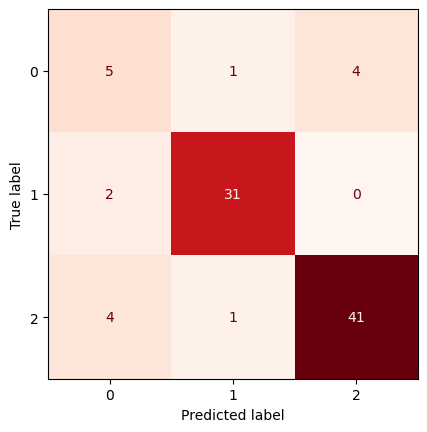

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Matriz de confusion (con una)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, cmap="Reds", colorbar=False)

# ACCURACY
acc_custom = accuracy_score(y_test, y_pred)
print(f"-> Accuracy/Precisión Custom MLP: {acc_custom * 100:.2f}%")

# RECALL
recall_custom = recall_score(y_test, y_pred, average='micro')
print(f"-> Recall Custom MLP: {recall_custom * 100:.2f}%")

# PRECISION
prec_custom = precision_score(y_test, y_pred, average='macro')
print(f"-> Precision Custom MLP: {prec_custom * 100:.2f}%")

# F1 Score
f1_custom = f1_score(y_test, y_pred, average='macro')
print(f"-> F1 Score Custom MLP: {f1_custom * 100:.2f}%")

Text(0.5, 1.0, 'SKLearn\nAcc: 80.90%')

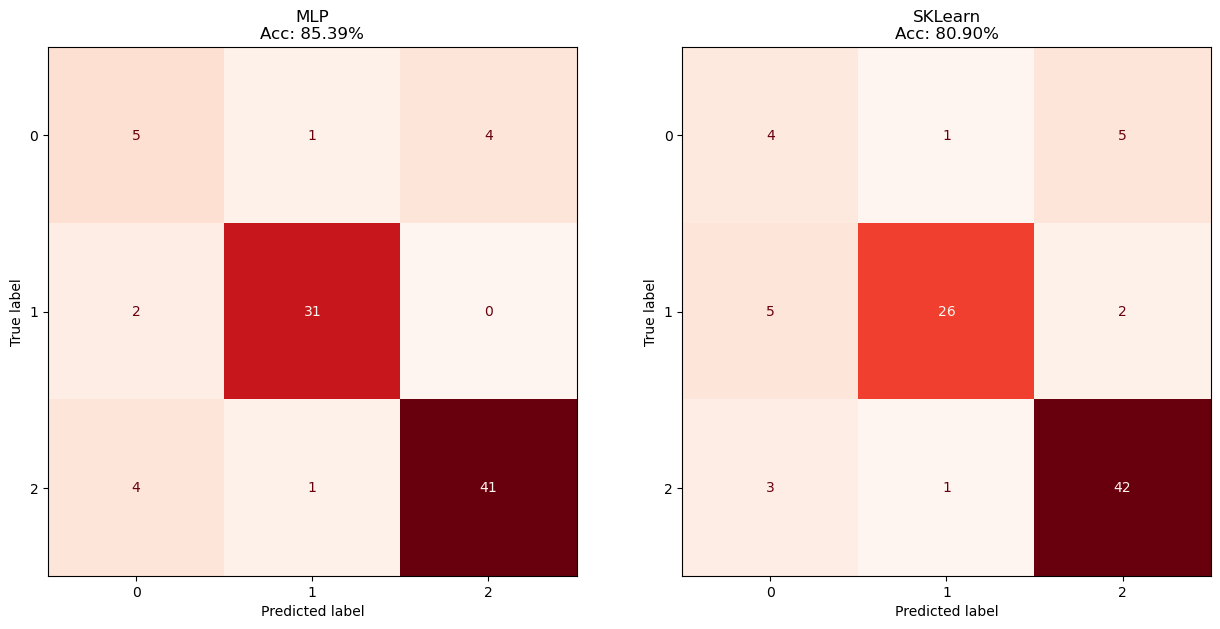

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusion (con varias)
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes = axes.flatten()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, ax=axes[0], cmap="Reds", colorbar=False)
axes[0].set_title(f"MLP\nAcc: {acc_custom * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=axes[1], cmap="Reds", colorbar=False)
axes[1].set_title(f"SKLearn\nAcc: {acc_dt * 100:.2f}%")

### DIAGNOSTICO

   | (coste) | validacion baja | validacion alta | 
   |---|---|---|
   | entrenamiento bajo | precision alta (lo que queremos) | overfitting (overfitting, tmb se puede ir subiendo lambda con cuidado) |
   | entrenamiento alto | datos de validacion sesgados (modelo mal) | modelo mal |